In [76]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

(2270, 2525, 3)


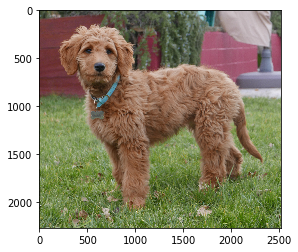

In [93]:
im = cv2.imread("./doodle.jpg") #3.6 MB
shape = im.shape
print(shape)
h = shape[0]
w = shape[1]

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()

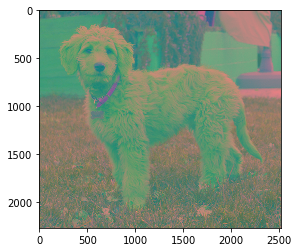

True

In [97]:
ycc = cv2.cvtColor(im,cv2.COLOR_RGB2YCrCb);
plt.imshow(ycc)
plt.show()
cv2.imwrite("./doodle_ycc.jpg",ycc)
cv2.imwrite("./doodle_y.jpg",ycc[:,:,0])
cv2.imwrite("./doodle_Cr.jpg",ycc[:,:,1])
cv2.imwrite("./doodle_Cb.jpg",ycc[:,:,1])

In [100]:
#JPEG algo splits image into 8x8 blocks, so we need to crop to dimensions divisible by 8
hmax = h - (h%8)
wmax = w - (w%8)
ycc = ycc[:hmax,:wmax,:]

print(ycc.shape)
cv2.imwrite("./doodle_ycc_cropped.jpg",ycc)

(2264, 2520, 3)


True

TO DO: Explain derivation of DCT, and why it's better than FFT in this case

In [129]:
#define transform matrix T such that the DCT of image M is given by TMT'
T = np.zeros((8,8))
T[0,:] = [1/np.sqrt(8) for i in range(8)]
for i in range(1,8):
    for j in range(8):
        T[i,j] = 0.5 * np.cos(((2*j + 1)*i*np.pi)/16)
        
T_inv = np.linalg.inv(T)

In [238]:
#define JPEG standard quantization matrix
Q=np.array([[16,11,10,16,24,40,51,61],
   [12,12,14,19,26,58,60,55],
   [14,13,16,24,40,57,69,56],
   [14,17,22,29,51,87,80,62],
   [18,22,37,56,68,109,103,77],
   [24,35,55,64,81,104,113,92],
   [49,64,78,87,103,121,120,101],
   [72,92,95,98,112,100,103,99],
   ])

In [239]:
#scale the quanitization to remove more or less frequencies from the image
reg_quality = 1
good_quality = 0.1
poor_quality = 20

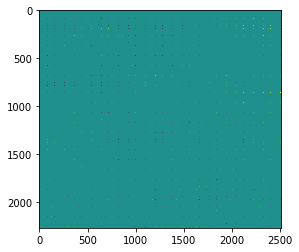

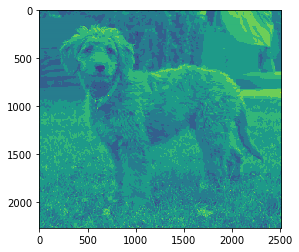

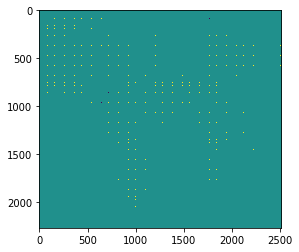

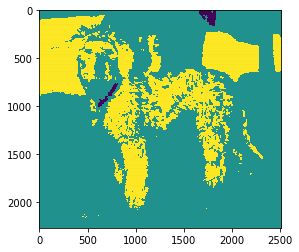

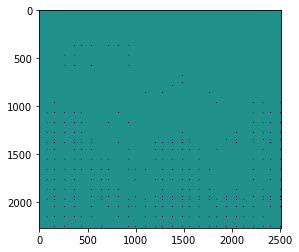

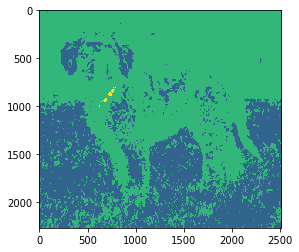

True

In [240]:
#transform each of the Y, Cr, and Cb spaces separately
final = np.zeros((hmax,wmax,3),np.uint8)
Q = Q*poor_quality
for k in range(3):
    start = np.array(ycc[:,:,k])
    start = start - float(128) #shift pixel values from [0,256] to [-128,127] to reduce range requirements for DCT processing
    compressed = np.zeros((hmax,wmax)) #initialize a matrix to piece blocks back together
    
    for i in range(int(hmax/8)):
        for j in range(int(wmax/8)):
            block = start[8*i:8*(i+1), 8*j:8*(j+1)] #eg blocks go from [0,7],[8,15],[16,23],...
            #plt.imshow(block)
            #plt.show()
            #print(block)
            
            D = T @ block @ T_inv #DCT on block
            #plt.imshow(D)
            #plt.show()
            #print(D)
            
            C = D/Q #divide by quantization matrix...highest frequencies will be made smallest 
            C = np.round(C) #round to integer pixel values (lossy step)
            #plt.imshow(C)
            #plt.show()
            #print(C) #note that most of the frequencies have been reduced to 0
            compressed[8*i:8*(i+1), 8*j:8*(j+1)] = C
                 
    #decompress image and run inverse fourier transform
    plt.imshow(compressed)
    plt.show()
    #print(compressed)
    
    decompressed = np.zeros((hmax,wmax))
    for i in range(int(hmax/8)):
        for j in range(int(wmax/8)):
            block = compressed[8*i:8*(i+1), 8*j:8*(j+1)]
            C = block * Q #piecewise multiply by quantization matrix
            D_inv = T_inv @ C @ T #writing as matrix multiplication makes taking the inverse DCT easy
            decompressed[8*i:8*(i+1), 8*j:8*(j+1)] = D_inv
    
    decompressed = decompressed + float(128)
    decompressed = decompressed.astype(int)
    
    plt.imshow(decompressed)
    plt.show()
    
    final[:,:,k] = decompressed

cv2.imwrite("./doodle_ycc_poorfinal.jpg",final)

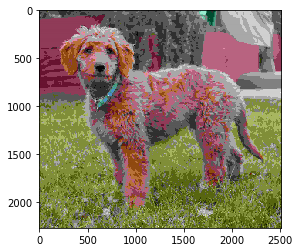

In [241]:
#with q=(1,1,1), the final compressed image size is 958 KB with no discernible loss in quality
final_bgr = cv2.cvtColor(final,cv2.COLOR_YCrCb2BGR);
cv2.imwrite("./doodle_poorfinal.jpg",final_bgr) 

final_rgb = cv2.cvtColor(final_bgr,cv2.COLOR_BGR2RGB);
plt.imshow(final_rgb)
plt.show()